In [230]:
library(ggplot2)
library(cowplot)
library(reshape2)

In [231]:
asv_tab <- read.table("data/asv_table.tab", comment.char="", header=1, skip=1, sep="\t", row.names=1)
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)
md <- read.table("data/METADATA.txt", sep="\t", header=1, row.names=1, comment.char="")
asv_tab <- scale(asv_tab, center=FALSE, scale=colSums(asv_tab))
asv_tab <- merge(taxonomy, asv_tab, by=0)
asv_tab <- melt(asv_tab[,! colnames(asv_tab) %in% c("Confidence")]) # Exclude the confidence column
asv_tab$variable <- gsub("^X","", asv_tab$variable)

Using Row.names, Taxon as id variables


In [232]:
cut_taxonomy_string <- function(x, n) {
    sp <- unlist(strsplit(x,";"))
    if (length(sp) >= n) {
        return(sp[n])
        }
    else {
        return(sp[length(sp)])
    }
}

get_melted_taxon_table <- function(n) {
    rel_abund_tab <- aggregate(asv_tab$value, by=list(asv_tab$variable, asv_tab$Taxon), FUN=sum)
    colnames(rel_abund_tab) <- c("SampleID", "Taxon", "RelAbund")
    rel_abund_tab$Classification <- unlist(lapply(as.character(rel_abund_tab$Taxon), function(x) cut_taxonomy_string(x, n)))
    rel_abund_tab
}

## Table 1

In [233]:
phylum_tab <- get_melted_taxon_table(2)
# Aggregate and normalize by location
phylum_tab$Location <- md[rel_abund_tab$SampleID,'location']
phylum_tab$Location <- as.factor(phylum_tab$Location)
levels(phylum_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
phylum_tab <- aggregate(phylum_tab$RelAbund, by=list(phylum_tab$Location, phylum_tab$Classification), FUN=sum)
colnames(phylum_tab) <- c("Location", "Classification", "RelAbund")
phylum_tab[phylum_tab$Location == 'Vero Beach','RelAbund'] <- phylum_tab[phylum_tab$Location == 'Vero Beach','RelAbund']/4*100
phylum_tab[phylum_tab$Location == 'Palmetto Inland','RelAbund'] <- phylum_tab[phylum_tab$Location == 'Palmetto Inland','RelAbund']/6*100
phylum_tab[phylum_tab$Location == 'Palmetto Beach','RelAbund'] <- phylum_tab[phylum_tab$Location == 'Palmetto Beach','RelAbund']/6*100
# Round for pretty print
phylum_tab$RelAbund <- round(phylum_tab$RelAbund, 2)
# Re-cast as wide for viewing
phylum_tab <- dcast(data = phylum_tab, formula = Classification~Location,fun.aggregate = sum,value.var = "RelAbund")
# Order by largest row sums
phylum_tab <- phylum_tab[order(rowSums(phylum_tab[,2:4]), decreasing=TRUE),]                                    
phylum_tab

,Classification,Palmetto Inland,Palmetto Coast,Vero Beach
23,D_1__Proteobacteria,65.32,2.12,99.72
26,D_1__Spirochaetes,15.88,1.84,0.00
27,D_1__Tenericutes,10.39,0.80,0.00
5,D_1__Actinobacteria,2.92,0.34,0.01
7,D_1__Bacteroidetes,2.73,0.21,0.00
15,D_1__Firmicutes,0.66,0.26,0.04
29,Unassigned,0.70,0.23,0.01
14,D_1__Epsilonbacteraeota,0.51,0.00,0.03
11,D_1__Cyanobacteria,0.06,0.04,0.17
4,D_1__Acidobacteria,0.19,0.04,0.00


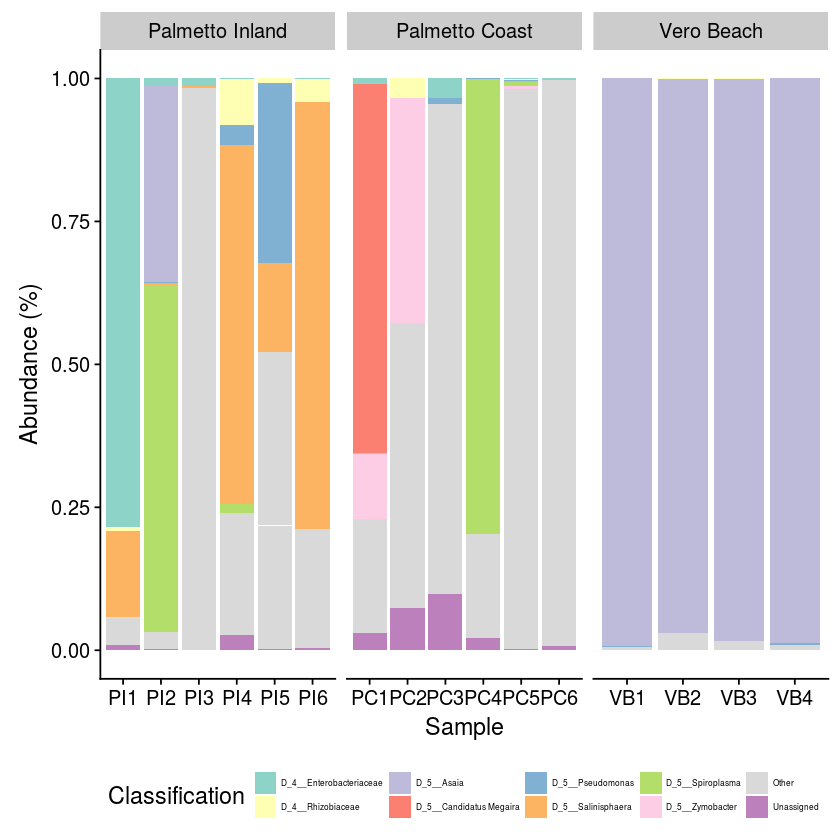

In [242]:
genus_tab <- get_melted_taxon_table(6)
mean_tab <- aggregate(genus_tab$RelAbund, by=list(genus_tab$Classification), FUN=mean)
abundant <- mean_tab[mean_tab$x > 0.01,"Group.1"]
genus_tab[! genus_tab$Classification %in% abundant, "Classification"] <- "Other"
genus_tab$Location <- md[genus_tab$SampleID,"location"]
genus_tab$Location <- as.factor(genus_tab$Location)
levels(genus_tab$Location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
genus_tab$SampleID <- as.factor(genus_tab$SampleID)
levels(genus_tab$SampleID) <- c("VB1","VB2","VB3","VB4","PC1","PC2","PC3","PC4","PC5","PI1","PI2","PI3","PI4","PI5","PI6","PC6")
ggplot(genus_tab, aes(x=SampleID, y=RelAbund, fill=Classification)) + 
    geom_bar(stat='identity') + theme(legend.position='bottom', legend.text=element_text(size=5)) +
    scale_fill_brewer(palette='Set3') + facet_grid(.~Location, scales = "free") + xlab("Sample") + ylab("Abundance (%)")